<a href="https://colab.research.google.com/github/Cecax27/DS-Stardew-Valley-Crops-Profit/blob/main/notebooks/Stardew_valley_analysis_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis data

Previously, I extracted information from Stardew Valley Wiki about the crops and theirs seeds. You can see the notebook on: [Stardew_valley_web_scraper.ipynb](https://github.com/Cecax27/DS-Stardew-Valley-Crops-Profit/blob/main/notebooks/Stardew_valley_web_scraper.ipynb)
After, I preprocessed the data, clean some information and improve the quality of the dataset. Also you can find the notebook on: [Stardew_valley_transform_data.ipynb](https://github.com/Cecax27/DS-Stardew-Valley-Crops-Profit/blob/main/notebooks/Stardew_valley_transform_data.ipynb)

In this notebook I'll start to analysis the data, resolve some questions.

The url of the wiki website is https://stardewvalleywiki.com. You can visit it to find a lot of information about the game.

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [2]:
%matplotlib inline
sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rcParams['figure.figsize'] = (7, 5)

## Loading data from csv

In [3]:
df = pd.read_csv('../data/crops_preprocessed_data.csv')

print(f'DataFrame created with {df.shape[0]} rows and {df.shape[1]} columns\n')
print('Columns:')
print(df.dtypes)

DataFrame created with 43 rows and 25 columns

Columns:
name                         object
artisan_sell_price           object
base                         object
description                  object
egg_festival_price          float64
energy                       object
general_store_price         float64
growth_time                   int64
jojamart_price              float64
night_market_price          float64
oasis_price                 float64
regrowth_time                 int64
seed                         object
sell_price_gold             float64
sell_price_iridium          float64
sell_price_regular          float64
sell_price_silver           float64
source                       object
traveling_cart_price_max    float64
traveling_cart_price_min    float64
xp                           object
spring                       object
summer                       object
fall                         object
winter                       object
dtype: object


## Analysis data

First, I want to calculate a new measurement, the **gold per day**. There's some ideas:
* There are some crops that you need to plant, grow and you harvest, and the cycle starts again. Another crops, after you harverst, continues to produce after maturity. To compare both types, we are going to calculate how many products you can get per season (28 days) and how much money do you get if you sell in regular quality.
* The formula will be:
$$\frac{{Production\ per\ season} * {Sell\ price - Cheapest\ purchase\ price}}{Season\ days (28)}$$

In [4]:
# Function to calculate production per season
def production_per_season(growth_time, regrowth_time) -> int:

    if growth_time == 0:
        return 0

    actual_day = 1
    production = 0
    first_harvest = False

    while actual_day < 29:

        # The first harvest
        if not first_harvest:
            actual_day += growth_time
            first_harvest = True

        # Other case
        else:
            # If the crop regrowth
            if regrowth_time != 0:
                actual_day += regrowth_time

            else:
                actual_day += growth_time

        if actual_day < 29:
            production += 1

    return production

In [5]:
# Testing
production_per_season(8, 4)

5

In [6]:
# Calculating production per season of all crops
df['production_per_season'] = (
    df
    .apply(
        lambda row: production_per_season(row['growth_time'], row['regrowth_time']),
        axis = 1
    )
)

In [7]:
df[['name', 'growth_time', 'regrowth_time', 'production_per_season']].head()

,name,growth_time,regrowth_time,production_per_season
0,Amaranth,7,0,3
1,Ancient Fruit,28,7,0
2,Artichoke,8,0,3
3,Beet,6,0,4
4,Blue Jazz,7,0,3


### Cheapest purchase price

In [8]:
print('Columns:')
print(df.dtypes)

Columns:
name                         object
artisan_sell_price           object
base                         object
description                  object
egg_festival_price          float64
energy                       object
general_store_price         float64
growth_time                   int64
jojamart_price              float64
night_market_price          float64
oasis_price                 float64
regrowth_time                 int64
seed                         object
sell_price_gold             float64
sell_price_iridium          float64
sell_price_regular          float64
sell_price_silver           float64
source                       object
traveling_cart_price_max    float64
traveling_cart_price_min    float64
xp                           object
spring                       object
summer                       object
fall                         object
winter                       object
production_per_season         int64
dtype: object


In [9]:
df['cheapest_purchase_price'] = (
    df
    .apply(
        lambda row: np.nanmin([
                        row['egg_festival_price'],
                        row['general_store_price'],
                        row['jojamart_price'],
                        row['night_market_price'],
                        row['oasis_price'],
                        row['traveling_cart_price_min']
                    ]),
        axis=1
    )
)

C:\Users\User\AppData\Local\Temp\ipykernel_7012\1363505700.py:4: RuntimeWarning: All-NaN axis encountered
  lambda row: np.nanmin([


In [10]:
df[[
    'name',
    'egg_festival_price',
    'general_store_price',
    'jojamart_price',
    'night_market_price',
    'oasis_price',
    'traveling_cart_price_min',
    'cheapest_purchase_price'
]].head()

,name,egg_festival_price,general_store_price,jojamart_price,night_market_price,oasis_price,traveling_cart_price_min,cheapest_purchase_price
0,Amaranth,NaN,70.0,87.0,NaN,NaN,105.0,70.0
1,Ancient Fruit,NaN,NaN,NaN,NaN,NaN,100.0,100.0
2,Artichoke,NaN,30.0,NaN,NaN,NaN,100.0,30.0
3,Beet,NaN,NaN,NaN,NaN,20.0,100.0,20.0
4,Blue Jazz,NaN,30.0,37.0,30.0,NaN,100.0,30.0


### Gold per day
How the sell price its diferent depending the quality, I will calculate a diferente gold per day value to each quality.

$$\frac{{Production\ per\ season} * {Sell\ price - Cheapest\ purchase\ price}}{Season\ days (28)}$$

In [11]:
df['gold_per_day_regular'] = (
    df
    .apply(
        lambda row: ( row['production_per_season'] * ( row['sell_price_regular'] - row['cheapest_purchase_price'] ) ) / (28),
        axis=1
    )
)

df['gold_per_day_silver'] = (
    df
    .apply(
        lambda row: ( row['production_per_season'] * ( row['sell_price_silver'] - row['cheapest_purchase_price'] ) ) / (28),
        axis=1
    )
)

df['gold_per_day_gold'] = (
    df
    .apply(
        lambda row: ( row['production_per_season'] * ( row['sell_price_gold'] - row['cheapest_purchase_price'] ) ) / (28),
        axis=1
    )
)

df['gold_per_day_iridium'] = (
    df
    .apply(
        lambda row: ( row['production_per_season'] * ( row['sell_price_iridium'] - row['cheapest_purchase_price'] ) ) / (28),
        axis=1
    )
)

In [30]:
df[[
    'name',
    'gold_per_day_regular',
    'gold_per_day_silver',
    'gold_per_day_gold',
    'gold_per_day_iridium'
]].head()

,name,gold_per_day_regular,gold_per_day_silver,gold_per_day_gold,gold_per_day_iridium
0,Amaranth,8.571429,12.535714,16.607143,24.642857
1,Ancient Fruit,0.000000,0.000000,0.000000,0.000000
2,Artichoke,13.928571,18.214286,22.500000,31.071429
3,Beet,11.428571,15.000000,18.571429,25.714286
4,Blue Jazz,2.142857,3.428571,4.821429,7.500000


## What is the more profitable crop?

To answer that, first I want to be sure if I order the crops by gold per day, the list will be in the same order for all the qualities. If not, we will analyze how the quality probabilities can affect our own crops.

In [13]:
regular_order = df.sort_values(by = 'gold_per_day_regular', ascending= False).name.to_list()
silver_order = df.sort_values(by = 'gold_per_day_silver', ascending= False).name.to_list()
gold_order = df.sort_values(by = 'gold_per_day_gold', ascending= False).name.to_list()
iridium_order = df.sort_values(by = 'gold_per_day_iridium', ascending= False).name.to_list()

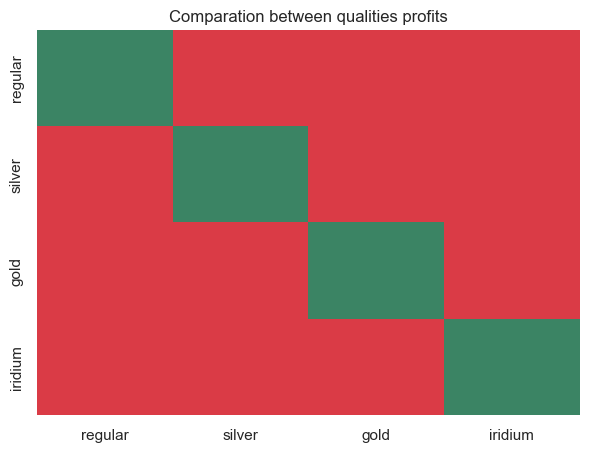

In [14]:
# Create a list of all the lists
all_lists = [regular_order, silver_order, gold_order, iridium_order]

# Initialize a matrix to store the comparison results
matrix = np.zeros((len(all_lists), len(all_lists)))

# Compare each pair of lists
for x in range(len(all_lists)):
    for y in range(len(all_lists)):
        if all_lists[x] == all_lists[y]:
            matrix[x][y] = 1

# Create a color map
cmap = sns.diverging_palette(10, 150, as_cmap=True)

# Create a Seaborn heatmap to visualize the results
sns.heatmap(matrix, cmap=cmap, xticklabels=('regular', 'silver', 'gold', 'iridium'),
            yticklabels=('regular', 'silver', 'gold', 'iridium'), cbar=False)

# Display the plot
plt.title('Comparation between qualities profits')
plt.show()

As we can see, the order is different between the different qualities. It's meant, depending on the probabilities of each quality, is probably one crop can be more profitable than another one.

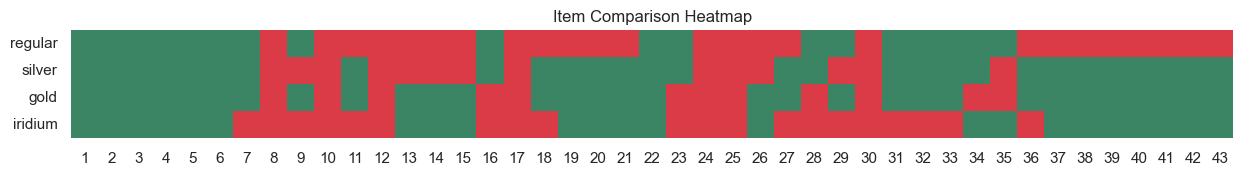

In [15]:
# Initialize a matrix to store the comparison results
matrix = np.zeros((len(all_lists),len(all_lists[0])))

# Compare each pair of lists
for i, lst in enumerate(all_lists):
    for j, item in enumerate(lst):
        for k, other_lst in enumerate(all_lists):
            if k != i and j < len(other_lst) and item == other_lst[j]:
                matrix[i, j] = 1

# Create a color map
cmap = sns.diverging_palette(10, 150, as_cmap=True)

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 9))

# Create a Seaborn heatmap
sns.heatmap(matrix, cmap=cmap,
            yticklabels=('regular', 'silver', 'gold', 'iridium'), xticklabels=range(1, len(all_lists[0])+1),
            cbar=False, square=True, ax=ax)

# Add a title to the plot
plt.title("Item Comparison Heatmap")

# Display the plot
plt.show()

Only the top 6 it's the same position independent of the quality, but practically the rest of the crops change their position.

In [16]:
# Top 6
(
    df
    .sort_values(by='gold_per_day_regular', ascending=False)
    .head(6)
    [[
        'name',
        'gold_per_day_regular',
        'spring',
        'summer',
        'fall',
        'winter'
    ]]
)

,name,gold_per_day_regular,spring,summer,fall,winter
35,Sweet Gem Berry,85.714286,False,False,True,False
31,Starfruit,25.000000,False,True,False,False
29,Red Cabbage,17.142857,False,True,False,False
27,Pumpkin,15.714286,False,False,True,False
2,Artichoke,13.928571,False,False,True,False
21,Melon,12.142857,False,True,False,False


## Quality formula

According the wiki, the probability that a crop's quality increases is linear with respect to your **farming level** (from 1 to 10) and the soil fertilizer quality (0 for normal soil, 1 for Basic Fertilizer, 2 for Quality Fertilizer, and 3 for Deluxe Fertilizer). That is, the probability increases the same amount with each level for the same fertilizer quality, and with each fertilizer quality for the same farming level.

The formulas used in the game's code are as follows: 

* **Gold**: $0.2 * (\frac{farming\ level}{10}) + 0.2 * (fertilizer\ level) * (\frac{farming\ level+2}{ 12}) + 0.01$
* **Silver**: 2 * chance for gold quality (capped at 75%) 
* **Iridium**: chance for gold quality / 2

Additionally, if the fertilizer is deluxe or better, then silver is the guaranteed minimum quality, and iridium is made possible. 

Example:

$$ Fertilizer\ level = Quality\ Fertilizer = 2 $$
$$ Farming\ level = 1$$
$$Gold = 0.2 * \frac{1}{10} + 0.2 * 2 * \frac{1 + 2}{12} + 0.01 = 0.13 = 13\% $$
$$Silver = min(0.75, 2 * 0.13) = 0.26 = 26\% $$
$$Iridium = \frac{0.13}{2} = 0.065 = 6.5\% $$

There are two parameters to considerer in probabilites: Farming level, and fertilizer level.


In [17]:
# Function to calculate quality probabilities
def calculate_quality_probabilities(farming_level, fertilizer_level) -> dict:

    probabilities = dict()

    probabilities['gold'] = ( 0.2 * (farming_level / 10)) + ( 0.2 * fertilizer_level * ( (farming_level + 2) / 12 ) ) + 0.01
    probabilities['silver'] = min(0.75, 2* probabilities['gold'])
    probabilities['iridium'] = probabilities['gold'] / 2

    return probabilities

In [18]:
# Testing
calculate_quality_probabilities(10, 3)

{'gold': 0.81, 'silver': 0.75, 'iridium': 0.405}

Text(0.5, 1.0, 'Iridium')

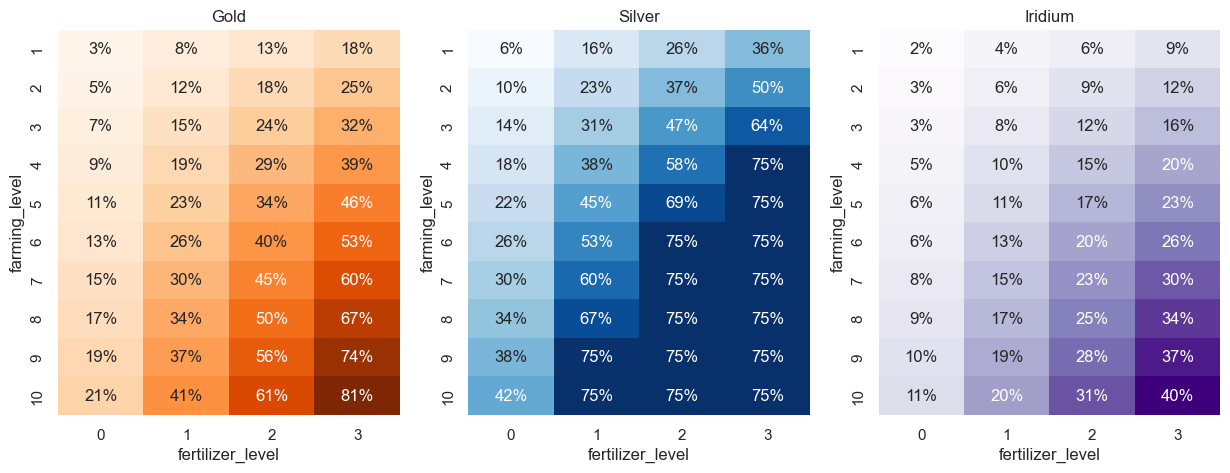

In [19]:
# Get probabilities heatmap
farming_level = np.arange(1, 11)
fertilizer_level = np.arange(4)

df_probabilities = pd.DataFrame({'farming_level': np.repeat(farming_level, len(fertilizer_level)),
                   'fertilizer_level': np.tile(fertilizer_level, len(farming_level))})


df_probabilities['probabilities_gold'] = (
    df_probabilities
    .apply(
        lambda row: calculate_quality_probabilities(row['farming_level'], row['fertilizer_level'])['gold'],
        axis=1
    )
)

df_probabilities['probabilities_silver'] = (
    df_probabilities
    .apply(
        lambda row: calculate_quality_probabilities(row['farming_level'], row['fertilizer_level'])['silver'],
        axis=1
    )
)

df_probabilities['probabilities_iridium'] = (
    df_probabilities
    .apply(
        lambda row: calculate_quality_probabilities(row['farming_level'], row['fertilizer_level'])['iridium'],
        axis=1
    )
)

gold_df = df_probabilities.pivot(index='farming_level', columns='fertilizer_level', values='probabilities_gold')
silver_df = df_probabilities.pivot(index='farming_level', columns='fertilizer_level', values='probabilities_silver')
iridium_df = df_probabilities.pivot(index='farming_level', columns='fertilizer_level', values='probabilities_iridium')

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Create the first heatmap
sns.heatmap(gold_df, cmap='Oranges', annot=True, fmt=".0%", ax=axs[0], cbar=False)
axs[0].set_title('Gold')

# Create the second heatmap
sns.heatmap(silver_df, cmap='Blues', annot=True, fmt=".0%", ax=axs[1], cbar=False)
axs[1].set_title('Silver')

# Create the third heatmap
sns.heatmap(iridium_df, cmap='Purples', annot=True, fmt=".0%", ax=axs[2], cbar=False)
axs[2].set_title('Iridium')


In [20]:
gold_df.to_csv('../data/gold_probabilities.csv')
silver_df.to_csv('../data/silver_probabilities.csv')
iridium_df.to_csv('../data/iridium_probabilities.csv')

## Finding the best crop for spring
Now, we are going to filter the data to work only with spring crops.

In [21]:
df_spring = df[df['spring'] == True]
print(f"We have {df_spring.shape[0]} spring crops")

We have 14 spring crops


<Axes: xlabel='gold_per_day_regular', ylabel='name'>

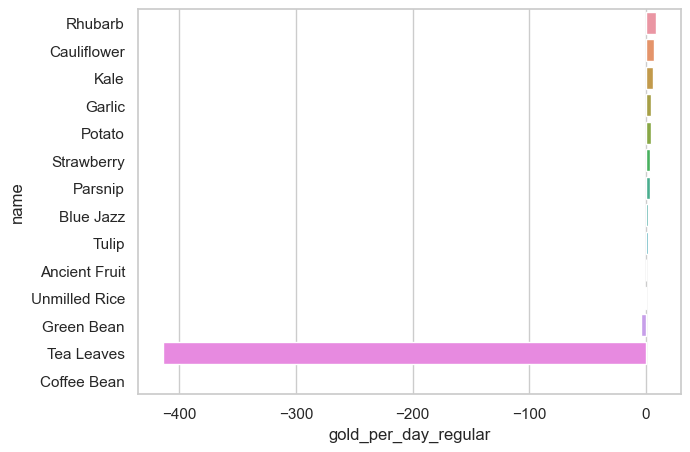

In [22]:
sns.barplot(
    data = df_spring.sort_values(by = 'gold_per_day_regular', ascending=False),
    x = 'gold_per_day_regular',
    y = 'name'
)

In here we have a problem. Tea Leaves have gold per day negative. It's because Tea Sapling its expensive to buy, but you can crafting it. Anyway, it isn't a good crop, so we are going to delete.

In [23]:
df_spring = df_spring.drop(df[df['name'] == 'Tea Leaves'].index)

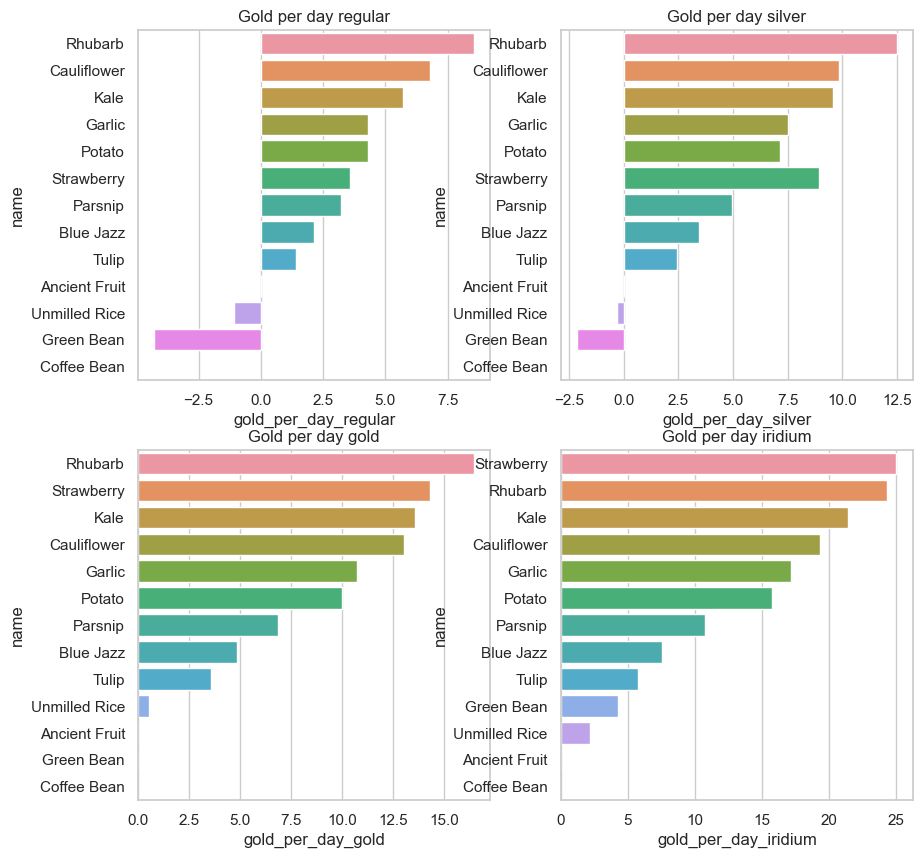

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.barplot(
    data = df_spring.sort_values(by = 'gold_per_day_regular', ascending=False),
    x = 'gold_per_day_regular',
    y = 'name',
    ax=axs[0][0]
)
axs[0][0].set_title('Gold per day regular')

sns.barplot(
    data = df_spring.sort_values(by = 'gold_per_day_regular', ascending=False),
    x = 'gold_per_day_silver',
    y = 'name',
    ax=axs[0][1],
)
axs[0][1].set_title('Gold per day silver')

sns.barplot(
    data = df_spring.sort_values(by = 'gold_per_day_gold', ascending=False),
    x = 'gold_per_day_gold',
    y = 'name',
    ax=axs[1][0],
)
axs[1][0].set_title('Gold per day gold')

sns.barplot(
    data = df_spring.sort_values(by = 'gold_per_day_iridium', ascending=False),
    x = 'gold_per_day_iridium',
    y = 'name',
    ax=axs[1][1],
)
axs[1][1].set_title('Gold per day iridium')

plt.show()

In [25]:
df_spring

,name,artisan_sell_price,base,description,egg_festival_price,energy,general_store_price,growth_time,jojamart_price,night_market_price,...,spring,summer,fall,winter,production_per_season,cheapest_purchase_price,gold_per_day_regular,gold_per_day_silver,gold_per_day_gold,gold_per_day_iridium
1,Ancient Fruit,NaN,Artisan (+40%),It's been dormant for eons.,NaN,Inedible,NaN,28,NaN,NaN,...,True,True,True,False,0,100.0,0.000000,0.000000,0.000000,0.000000
4,Blue Jazz,NaN,Artisan (+40%),The flower grows in a sphere to invite as many...,NaN,NaN,30.0,7,37.0,30.0,...,True,False,False,False,3,30.0,2.142857,3.428571,4.821429,7.500000
8,Cauliflower,NaN,Artisan (+40%),"Valuable, but slow-growing. Despite its pale c...",NaN,NaN,80.0,12,100.0,80.0,...,True,False,False,False,2,80.0,6.785714,9.857143,13.000000,19.285714
9,Coffee Bean,150g,NaN,Plant in spring or summer to grow a coffee pla...,NaN,Inedible,NaN,10,NaN,NaN,...,True,True,False,False,9,NaN,NaN,NaN,NaN,NaN
15,Garlic,NaN,Artisan (+40%),Adds a wonderful zestiness to dishes. High qua...,NaN,NaN,40.0,4,NaN,40.0,...,True,False,False,False,6,40.0,4.285714,7.500000,10.714286,17.142857
17,Green Bean,NaN,Artisan (+40%),"A juicy little bean with a cool, crisp snap.",NaN,NaN,60.0,10,75.0,60.0,...,True,False,False,False,6,60.0,-4.285714,-2.142857,0.000000,4.285714
20,Kale,NaN,Artisan (+40%),The waxy leaves are great in soups and stir frys.,NaN,NaN,70.0,6,87.0,70.0,...,True,False,False,False,4,70.0,5.714286,9.571429,13.571429,21.428571
23,Parsnip,NaN,Artisan (+40%),A spring tuber closely related to the carrot. ...,NaN,NaN,20.0,4,25.0,20.0,...,True,False,False,False,6,20.0,3.214286,4.928571,6.857143,10.714286
26,Potato,NaN,Artisan (+40%),A widely cultivated tuber.,NaN,NaN,50.0,6,62.0,50.0,...,True,False,False,False,4,50.0,4.285714,7.142857,10.000000,15.714286
30,Rhubarb,NaN,Artisan (+40%),"The stalks are extremely tart, but make a grea...",NaN,Inedible,NaN,13,NaN,NaN,...,True,False,False,False,2,100.0,8.571429,12.500000,16.428571,24.285714


In [26]:
price_columns = ["general_store_price", "jojamart_price", "oasis_price", "egg_festival_price", "night_market_price", "traveling_cart_price_min"]

# Initialize the 'better_place_to_buy' column as empty
df_spring['better_place_to_buy'] = ""

# Iterate over each row
for index, row in df_spring.iterrows():
    cheapest_price = row['cheapest_purchase_price']
    
    # Iterate over each price column and compare the values
    for column in price_columns:
        if row[column] == cheapest_price:
            df_spring.at[index, 'better_place_to_buy'] = column.replace('_price', '').replace('_min', '').replace('_', ' ').capitalize()
            break

# Print the updated DataFrame
print(df_spring[['name','better_place_to_buy']])

             name better_place_to_buy
1   Ancient Fruit      Traveling cart
4       Blue Jazz       General store
8     Cauliflower       General store
9     Coffee Bean                    
15         Garlic       General store
17     Green Bean       General store
20           Kale       General store
23        Parsnip       General store
26         Potato       General store
30        Rhubarb               Oasis
32     Strawberry        Egg festival
39          Tulip       General store
40  Unmilled Rice       General store


In [27]:
# Preparing data to export to make a dashboard

# Define the suffixes for 'sell_price' and 'gold_per_day' columns
suffixes = ["regular", "silver", "gold", "iridium"]

# Create a list of value variables for melting
value_vars = ['sell_price_' + suffix for suffix in suffixes]
value_vars_gold = ['gold_per_day_' + suffix for suffix in suffixes]

# Melt the DataFrame
sell_price_df = pd.melt(df_spring, id_vars=['name', 'description', 'seed', 'growth_time', 'regrowth_time',
                                'production_per_season', 'cheapest_purchase_price', 'better_place_to_buy'],
                    value_vars=value_vars, var_name='quality', value_name='sell_price')

gold_per_day_df = pd.melt(df_spring, id_vars=['name', 'description', 'seed', 'growth_time', 'regrowth_time',
                                'production_per_season', 'cheapest_purchase_price', 'better_place_to_buy'],
                    value_vars=value_vars_gold, var_name='quality', value_name='gold_per_day')

sell_price_df['gold_per_day'] = gold_per_day_df['gold_per_day']

sell_price_df['quality'] = (
    sell_price_df
    ['quality']
    .apply(
        lambda row: row.split('_')[-1].strip().capitalize()
    )
)

sell_price_df.to_csv('../data/spring_crops.csv', index= False)